<a href="https://colab.research.google.com/github/abeersethia/CCM_EEG/blob/main/GilpinPaper_Unsuccessful.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


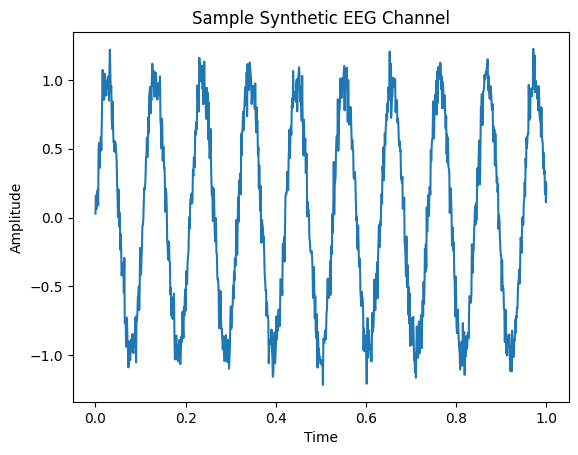

In [11]:
np.random.seed(42)
n_channels = 7      # EEG-like channels
n_samples = 1000    # Time steps
freqs = np.random.uniform(8, 12, size=n_channels)  # alpha-band frequencies

time = np.linspace(0, 1, n_samples)
signals = np.array([
    np.sin(2 * np.pi * f * time) + 0.1 * np.random.randn(n_samples)
    for f in freqs
]).T  # shape: (1000, 5)

# Plot a sample channel
plt.plot(time, signals[:, 0])
plt.title("Sample Synthetic EEG Channel")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [12]:
def create_hankel_matrix(data, T):
    """
    Create a Hankel matrix by rolling windows across time for multivariate signals.
    Each row represents a T x m block flattened to 1D.
    """
    N, m = data.shape
    hankel_rows = N - T + 1
    hankel_matrix = np.zeros((hankel_rows, T * m))
    for i in range(hankel_rows):
        window = data[i:i+T, :].T.reshape(-1)
        hankel_matrix[i, :] = window
    return hankel_matrix

T = 20  # Lag window size (embedding dimension)
X = create_hankel_matrix(signals, T)
print("Hankel matrix shape:", X.shape)

Hankel matrix shape: (981, 140)


In [13]:
# Normalise and Prepare Data Loader
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=32, shuffle=True)

In [14]:
class GilpinAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

input_dim = X_train.shape[1]
latent_dim = 10
model = GilpinAutoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)

In [15]:
def fnn_loss(z, K=5):
    """
    False Nearest Neighbor (FNN) Loss:
    Penalizes latent dimensions that do not preserve neighbor relationships.
    """
    B, L = z.shape
    z_np = z.detach().cpu().numpy()

    loss = 0.0
    for m in range(1, L):  # from dim 1 to L-1
        nbrs_m = NearestNeighbors(n_neighbors=K+1).fit(z_np[:, :m])
        _, indices_m = nbrs_m.kneighbors(z_np[:, :m])
        indices_m = indices_m[:, 1:]

        nbrs_m1 = NearestNeighbors(n_neighbors=K+1).fit(z_np[:, :m+1])
        _, indices_m1 = nbrs_m1.kneighbors(z_np[:, :m+1])
        indices_m1 = indices_m1[:, 1:]

        retained = (indices_m == indices_m1).sum(axis=1) / K
        mean_retention = retained.mean()
        dim_var = np.var(z_np[:, m])
        penalty = (1 - mean_retention) * dim_var
        loss += penalty

    return torch.tensor(loss, dtype=torch.float32, device=z.device)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
lambda_fnn = 1e-2

recon_losses = []
fnn_penalties = []

for epoch in range(50):
    epoch_recon = 0.0
    epoch_fnn = 0.0
    for batch in train_loader:
        x = batch[0]
        x_hat, z = model(x)

        recon_loss = criterion(x_hat, x)
        fnn_reg = fnn_loss(z)
        loss = recon_loss + lambda_fnn * fnn_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_recon += recon_loss.item()
        epoch_fnn += fnn_reg.item()

    recon_losses.append(epoch_recon / len(train_loader))
    fnn_penalties.append(epoch_fnn / len(train_loader))

    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d} | Recon Loss: {recon_losses[-1]:.5f} | FNN Penalty: {fnn_penalties[-1]:.5f}")

Epoch 00 | Recon Loss: 0.02676 | FNN Penalty: 40.01316
Epoch 05 | Recon Loss: 0.02072 | FNN Penalty: 39.40187
Epoch 10 | Recon Loss: 0.02092 | FNN Penalty: 39.18328
Epoch 15 | Recon Loss: 0.02057 | FNN Penalty: 38.81762
Epoch 20 | Recon Loss: 0.02052 | FNN Penalty: 38.73266
Epoch 25 | Recon Loss: 0.02040 | FNN Penalty: 38.27587
Epoch 30 | Recon Loss: 0.02060 | FNN Penalty: 37.22804
Epoch 35 | Recon Loss: 0.02032 | FNN Penalty: 35.81160
Epoch 40 | Recon Loss: 0.02006 | FNN Penalty: 36.27740
Epoch 45 | Recon Loss: 0.02017 | FNN Penalty: 36.38969


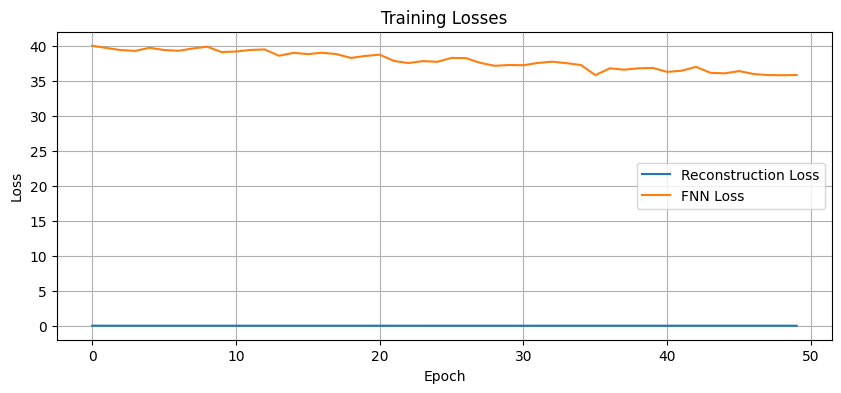

In [22]:
plt.figure(figsize=(10,4))
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(fnn_penalties, label='FNN Loss')
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

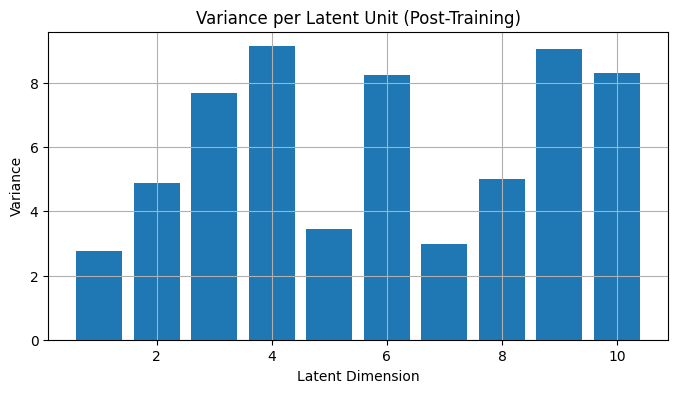

In [23]:
model.eval()
with torch.no_grad():
    _, z_all = model(X_train_tensor)

# Variance per latent unit
z_np = z_all.cpu().numpy()
latent_variance = np.var(z_np, axis=0)

plt.figure(figsize=(8,4))
plt.bar(range(1, latent_dim + 1), latent_variance)
plt.xlabel("Latent Dimension")
plt.ylabel("Variance")
plt.title("Variance per Latent Unit (Post-Training)")
plt.grid(True)
plt.show()